In [10]:
import numpy as np
import string
import os
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
reviews = "reviews.csv"
data_set = pd.read_csv(reviews)
data_set2 = pd.DataFrame(data_set, columns=['buisness_name','text']) 
data_set.head()




,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [15]:
Text = data_set['text']
buisness_name = data_set['business_name']

preprossed_text = []
stop_words = set(stopwords.words('english'))
stop_words.add('I')
stop_words.add('The')
stop_words.add('it')
st = ISRIStemmer()

for text in Text:
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.split()
    text = [st.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    preprossed_text.append(text)


data = pd.DataFrame({'business_name':buisness_name,'text':preprossed_text})
data.head()


,business_name,text
0,Haci'nin Yeri - Yigit Lokantasi,We went Marmaris wife holiday We chose restaur...
1,Haci'nin Yeri - Yigit Lokantasi,During holiday Marmaris ate fit food Its reall...
2,Haci'nin Yeri - Yigit Lokantasi,Prices affordable menu photo cost 108 liras Yo...
3,Haci'nin Yeri - Yigit Lokantasi,Turkeys cheapest artisan restaurant food delic...
4,Haci'nin Yeri - Yigit Lokantasi,dont know look terms price performance point t...


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(preprossed_text)


query =["bad service","good service","bad food","good food","bad ambience","good ambience","bad location","good location","bad price","good price","bad experience","good experience","bad staff","good staff","bad management","good management","bad quality","good quality","bad hygiene","good hygiene","bad taste","good taste","bad value","good value","bad decor","good decor","bad menu","good menu","bad drinks","good drinks","bad atmosphere","good atmosphere","bad music","good music","bad seating","good seating","bad crowd","good crowd","bad cleanliness","good cleanliness","bad lighting","good lighting","bad presentation","good presentation","bad portion","good portion","bad variety","good variety","bad selection","good selection","bad flavor","good flavor","bad smell","good smell","bad noise","good noise","bad temperature","good temperature"]

preprocessed_topics = []
st = ISRIStemmer()
for topic in query:
    processed_topic = topic.translate(str.maketrans('', '', string.punctuation))
    processed_topic = processed_topic.split()
    processed_topic = [st.stem(word) for word in processed_topic if not word in stop_words]
    processed_topic = ' '.join(processed_topic)
    preprocessed_topics.append(processed_topic)

vectorized_topics = vectorizer.transform(preprocessed_topics)




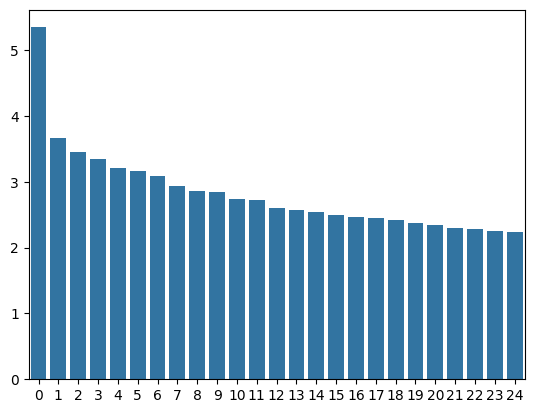

In [39]:
import seaborn as sns
lsa = TruncatedSVD(n_components=25)
lsa.fit(vectorized_data)
lsa_data = lsa.transform(vectorized_data)

lsa_query = lsa.transform(vectorized_topics)
sigma=lsa.singular_values_
sns.barplot(x=list(range(len(sigma))), y=sigma)

similarity = cosine_similarity(lsa_data,lsa_query)


In [43]:
rankings = np.argsort(similarity,axis=1)[::-1]

output = []
for i, text in enumerate(data_set['text']):
    most_relevant_topici_idx = rankings[i ,0]
    most_relevent_topic = query[most_relevant_topici_idx]
    output.append((text , most_relevent_topic))

# Print the most relevant review for each topic
for  review ,topic in output:
    print(f"Review: {review}\n Topic: {topic}\n\n")

Review: We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. You proceed by taking the food you want in the form of an open buffet. Both vegetable dishes and meat dishes were plentiful. There was also dessert for those who wanted it. After you get what you want you pay at the cashier. They don't go through cards they work in cash. There was a lot of food variety. And the food prices were unbelievably cheap. We paid only 84 TL for all the meals here. It included buttermilk and bread. But unfortunately I can't say it's too clean as a place..
 Topic: good cleanliness


Review: During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without bread. It is a place that I can recommend to those who will go to Marmaris. On J

In [13]:
rankings = np.argsort(similarity,axis=0)[::-1]
rankings = rankings.flatten()

output = []
scores = []
buisness_name_sorted = []
ratings_sorted = []
Query = []
origina_review_category = []

for rank in rankings:
    output.append(data_set['text'][rank])
    scores.append(similarity[rank][0])
    buisness_name_sorted.append(data_set['business_name'][rank])
    ratings_sorted.append(data_set['rating'][rank])
    Query.append(query)
    origina_review_category.append(data_set['rating_category'][rank])



print("Top 5 reviews for the query are:")
for i in range(5):
    print(output[i])
    print("Similarity Score: ", scores[i])
    print("\n")

Top 5 reviews for the query are:
The waiters took care of me. That's why I left the restaurant before I could order.
Similarity Score:  0.7557369378537463


The attitude of the waiters towards the customer was cold.
Similarity Score:  0.7076002384008174


Interest in Turkish customers was very low. All waiters were taking care of arab customers.
Similarity Score:  0.7061736526293354


The restaurant that made our four-day Gaziantep holiday poison! There is already excessive noise; it is impossible to hear the person next to you. The waiters are indifferent; the order takes too long to arrive.
Similarity Score:  0.6912988525256641


Food came late; pasta was cold. The waiters couldn't take care of us from taking care of the takeaway.
Similarity Score:  0.6874163617368154




In [14]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,original_review_category
0,Classic Thai,The waiters took care of me. That's why I left...,0.755737,1,waiter is rude,indoor_atmosphere
1,Umut Pide,The attitude of the waiters towards the custom...,0.707600,1,waiter is rude,indoor_atmosphere
2,Akpinar Restaurant,Interest in Turkish customers was very low. Al...,0.706174,1,waiter is rude,outdoor_atmosphere
3,Imam Cagdas,The restaurant that made our four-day Gaziante...,0.691299,1,waiter is rude,menu
4,Tavuk Dunyasi,Food came late; pasta was cold. The waiters co...,0.687416,2,waiter is rude,menu


In [18]:
words_topic_matrix = pd.DataFrame(lsa.components_,columns=vectorizer.get_feature_names_out())

#classifying most relevent words for each topic
top_words = []
for i in range(25):

    top_words.append(words_topic_matrix.loc[i].sort_values(ascending=False)[0:10])

# Function to concatenate words of each topic
def concatenate_words(topics):
    concatenated_strings = []
    for topic in topics:
        concatenated_strings.append(' '.join(topic.index))
    return concatenated_strings

# Generate the concatenated strings
concatenated_strings = concatenate_words(top_words)

# Print the results
for i, string in enumerate(concatenated_strings):
    print(f"Topic {i+1}: {string}")




Topic 1: good delicious place nice food service prices great taste it
Topic 2: great ambiance service recommend thanks thank dishes food everything appetizers
Topic 3: delicious food reasonable staff friendly fast prices recommend fresh quite
Topic 4: expensive place nice ambiance it crowded beautiful clean its amazing
Topic 5: prices high recommend expensive nice reasonable little bit flavors great
Topic 6: recommend expensive bad it taste definitely eat we ate service
Topic 7: nice recommend bad ambiance pizza service we excellent best not
Topic 8: good expensive recommend service food ambiance fast place nice excellent
Topic 9: bad service not taste food view fast beautiful staff friendly
Topic 10: food place recommend view bad beautiful high clean good eat
Topic 11: ambiance bad food amazing we not came liked little expensive
Topic 12: it ambiance taste bad delicious not good recommend best crowded
Topic 13: bad liked nice not good expensive delicious atmosphere great breakfast
Top

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [ ]:

# Create a dictionary and corpus
dictionary = corpora.Dictionary([review.split() for review in preprossed_text])
corpus = [dictionary.doc2bow(review.split()) for review in preprossed_text]

# Build LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")


Topic: 0 
Words: 0.028*"good" + 0.021*"place" + 0.019*"food" + 0.018*"delicious" + 0.016*"nice" + 0.015*"service" + 0.013*"taste" + 0.012*"It" + 0.008*"price" + 0.008*"employees"
Topic: 1 
Words: 0.022*"It" + 0.021*"We" + 0.020*"good" + 0.014*"delicious" + 0.011*"nice" + 0.011*"place" + 0.007*"ate" + 0.007*"breakfast" + 0.006*"really" + 0.006*"service"
Topic: 2 
Words: 0.013*"place" + 0.009*"order" + 0.008*"prices" + 0.008*"food" + 0.008*"came" + 0.008*"We" + 0.008*"It" + 0.007*"hamburger" + 0.007*"good" + 0.006*"menu"
Topic: 3 
Words: 0.021*"good" + 0.018*"place" + 0.011*"eat" + 0.011*"It" + 0.010*"taste" + 0.010*"bad" + 0.009*"much" + 0.008*"delicious" + 0.007*"nice" + 0.006*"food"
Topic: 4 
Words: 0.020*"place" + 0.017*"taste" + 0.016*"delicious" + 0.012*"good" + 0.011*"nice" + 0.010*"We" + 0.010*"Its" + 0.010*"really" + 0.009*"like" + 0.008*"service"


In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sid.polarity_scores(text)
    return 'positive' if scores['compound'] >= 0.05 else 'negative' if scores['compound'] <= -0.05 else 'neutral'

review_sentiments = [get_sentiment(review) for review in preprossed_text]
print(review_sentiments)


['negative', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', '

In [20]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query, 'review_sentiment':review_sentiments ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,review_sentiment,original_review_category
0,Classic Thai,The waiters took care of me. That's why I left...,0.755737,1,waiter is rude,negative,indoor_atmosphere
1,Umut Pide,The attitude of the waiters towards the custom...,0.707600,1,waiter is rude,positive,indoor_atmosphere
2,Akpinar Restaurant,Interest in Turkish customers was very low. Al...,0.706174,1,waiter is rude,positive,outdoor_atmosphere
3,Imam Cagdas,The restaurant that made our four-day Gaziante...,0.691299,1,waiter is rude,positive,menu
4,Tavuk Dunyasi,Food came late; pasta was cold. The waiters co...,0.687416,2,waiter is rude,neutral,menu


In [44]:
Topics = ["bad service","good service","bad food","good food","bad ambience","good ambience","bad location","good location","bad price","good price","bad experience","good experience","bad staff","good staff","bad management","good management","bad quality","good quality","bad hygiene","good hygiene","bad taste","good taste","bad value","good value","bad decor","good decor","bad menu","good menu","bad drinks","good drinks","bad atmosphere","good atmosphere","bad music","good music","bad seating","good seating","bad crowd","good crowd","bad cleanliness","good cleanliness","bad lighting","good lighting","bad presentation","good presentation","bad portion","good portion","bad variety","good variety","bad selection","good selection","bad flavor","good flavor","bad smell","good smell","bad noise","good noise","bad temperature","good temperature"]

# Preprocess the topics
stop_words = set(stopwords.words('english'))
preprocessed_topics = []
st = ISRIStemmer()
for topic in Topics:
    processed_topic = topic.translate(str.maketrans('', '', string.punctuation))
    processed_topic = processed_topic.split()
    processed_topic = [st.stem(word) for word in processed_topic if not word in stop_words]
    processed_topic = ' '.join(processed_topic)
    preprocessed_topics.append(processed_topic)

# Vectorize the topics
Vectorizer = TfidfVectorizer()
vectorized_topics = Vectorizer.fit_transform(preprocessed_topics)
Lsa = TruncatedSVD(n_components=25)
Lsa.fit(vectorized_topics)
Lsa_topics = Lsa.transform(vectorized_topics)

Vectorized_data = Vectorizer.transform(preprossed_text)

lsa_data = Lsa.transform(Vectorized_data)

# Calculate the similarity between the topics and the reviews
topic_similarities = cosine_similarity(lsa_data, Lsa_topics)
print(topic_similarities.shape)
# Get the most reviwe for each topic

rankings = np.argsort(topic_similarities,axis=1)[::-1]



output = []

for i, text in enumerate(data_set['text']):
    most_relevant_topici_idx = rankings[i ,0]
    most_relevent_topic = query[most_relevant_topici_idx]
    output.append((text , most_relevent_topic))

# Print the most relevant review for each topic
for  review ,topic in output:
    print(f"Review: {review}\n Topic: {topic}\n\n")




(1100, 58)
Review: We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. You proceed by taking the food you want in the form of an open buffet. Both vegetable dishes and meat dishes were plentiful. There was also dessert for those who wanted it. After you get what you want you pay at the cashier. They don't go through cards they work in cash. There was a lot of food variety. And the food prices were unbelievably cheap. We paid only 84 TL for all the meals here. It included buttermilk and bread. But unfortunately I can't say it's too clean as a place..
 Topic: good hygiene


Review: During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without bread. It is a place that I can recommend to those who will go to Marmari

# Supervised approach

In [5]:
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define your candidate labels (topics)
candidate_labels = ["customer service", "fees", "online banking", "mobile app", "account management"]

# Example reviews
reviews = [
    "The customer service is excellent.",
    "I had issues with online banking.",
    "The fees are too high.",
    "Great mobile app experience.",
    "I had trouble managing my account."
]

# Classify the reviews
for review in reviews:
    result = classifier(review, candidate_labels)
    print(f"Review: {review}")
    print(f"Predicted topic: {result['labels'][0]}")
    print(f"Scores: {result['scores']}")
    print("\n")


c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mohammed\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Pyt

Review: The customer service is excellent.
Predicted topic: customer service
Scores: [0.9688778519630432, 0.015073537826538086, 0.006695940159261227, 0.004960947670042515, 0.004391650203615427]


Review: I had issues with online banking.
Predicted topic: online banking
Scores: [0.7748580574989319, 0.1849270462989807, 0.02498571015894413, 0.010201596654951572, 0.0050275688990950584]


Review: The fees are too high.
Predicted topic: fees
Scores: [0.9729477763175964, 0.009804639965295792, 0.009582579135894775, 0.004946439992636442, 0.002718537813052535]


Review: Great mobile app experience.
Predicted topic: mobile app
Scores: [0.9828881621360779, 0.00540176359936595, 0.004695626441389322, 0.0035401780623942614, 0.0034743305295705795]


Review: I had trouble managing my account.
Predicted topic: account management
Scores: [0.9261687994003296, 0.053240641951560974, 0.006946783047169447, 0.006924341898411512, 0.006719393189996481]


